In [2]:
import numpy as np
from numpy import linalg
from matplotlib import pyplot as plt
%matplotlib inline

## Sectional method

Vector $u = \begin{bmatrix} u_0 \\ u_1 \\ \vdots \\ u_{N-1} \end{bmatrix}$ where $u_i$ are size bins with radii between $r_{min,i}$ and $r_{max,i}$

that satistfy the advection equation 

$ u_t - G u_r = 0 $

$ u_i^{k+1} = u_i^k - \frac{G \Delta t}{\Delta r} \left( u_i^k - u_{i-1}^k \right)$

with a left Neumann boundary condition $u_t = n_0$ is a nucleation rate, and a free boundary on the right. G is a linear crystal growth rate. 

Solve with Forward Euler:

In [171]:
def bubble_diffusion(R, u0, n0, G, t0, tf):
    """Calculate the bubble size distribution from 
    nucleation, growth by diffusion using forward Euler, 
    upwind scheme (first order in r and t)
    
    :Input:
    - *R*  (float)         - Maximum bubble radius.
    - *u0* (array_like(N)) - Initial bubble distribution. 
    - *n0* (float)         - Nucleation rate (1/s).
    - *G*  (float)         - Linear growth rate (m/s).
    - *t0* (float)         - Start time (s).
    - *tf* (float)         - End time (s).
    
    :Output: 
    - (array_like(N))      - Maximum size of each bin (m).
    - (array_like(N, m+2)) - Bubble number density in each size bin.
    - (array_like(m+2))    - Output times (s).
    """

    # Define timescale for true solution
    tau = 1/np.log(np.max([2 - G/n0, 1]))
    
    # Discretize size bins
    r = np.linspace(0,R,N+1)
    dr = r[1:] - r[:-1]
    rmin = r[:-1]
    rmax = r[1:]
    
    # Discretize time
    m = 10*np.ceil((tf-t0)*G/np.min(dr))
    m = int(m+10)
    t = np.linspace(t0, tf, m+2)
    dt = (tf-t0)/(m+1)
          
    # Intitialize solution
    u = np.zeros((N,m+2))
    u[:,0] = u0
    
    # Advection equation matrix operator for forward Euler, upwind
    diagonal = np.ones(N)
    A = np.diag(diagonal - G*dt/dr) + G*dt/dr*np.diag(diagonal[:-1],-1)

    # Solve
    for k,t_k in enumerate(t[:-1]):
        u[:,k+1] = np.matmul(A,u[:,k])
        u[0,k+1] += n0*dt # Boundary condition
        
    return rmax, u, t

C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater
C:\Users\Janine\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


[-3.42756775e+03 -4.51580421e-01]


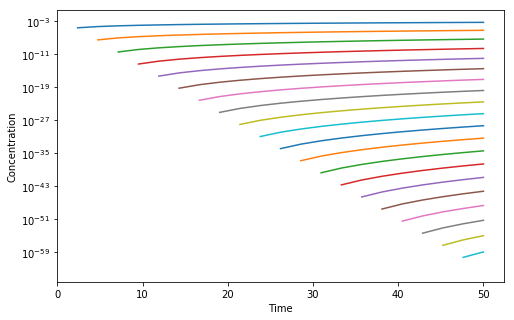

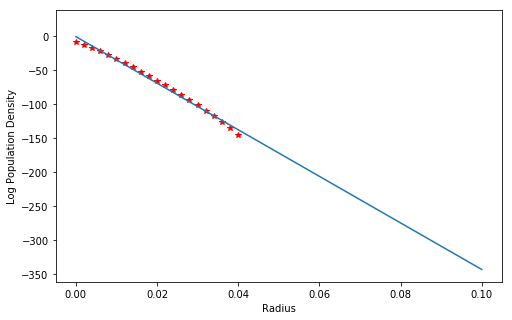

In [172]:
N = 50 # number of bins

# System parameters
n0 = 10**(-5) # nucleation rate
G = 10**(-6) # linear radial growth rate

# Time
t0 = 0
tf = 50

# Maximum radius of interest
R = 0.1

# Discretize size bins
r = np.linspace(0,R,N+1)
dr = r[1:] - r[:-1]
rmin = r[:-1]
rmax = r[1:]

# Initial condition
u0 = np.zeros(N)
u[0,0] = n0

# Solve
u, t = bubble_diffusion(R, u0, n0, G, t0, tf)

# Plotting
# Size distribution at all times
u[u==0] = 'nan'
fig,ax1 = plt.subplots(figsize=(8,5))
ax1.semilogy(t,u.transpose())
ax1.set_xlabel('Time')
ax1.set_ylabel('Concentration');

# Final population
fig,ax2 = plt.subplots(figsize=(8,5))
n = u[u[:,-1]>0,-1]
n_true = n0*np.exp(tf/tau-r/(G*tau)) # true solution

ax2.plot(rmin[u[:,-1]>0],np.log(n),'r*')
ax2.plot(r,np.log(n_true),'k')
ax2.set_xlabel('Radius')
ax2.set_ylabel('Log Population Density');

# Line of best fit for exponential distribution
c = np.polyfit(rmin[u[:,-1]>0],np.log(n),1)
p = np.poly1d(c)
ax2.plot(r,p(r))
print(c)

Coalescence is solved using the integro-differential Smoluchowski coagulation equation (Smoluchowski, 1916):

$ \frac{\partial n (V, t)}{\partial t} = \frac 1 2 \int_0^V H(V-V',V')n(V-V')n(V')dV' - n(V) \int_0^{\inf} H(V,V')n(V')dV' $

where V is the bubble volume, n is the number density at each volume, and H is the 'coagulation coefficient', generally a symmetric NxN matrix where the domain is divided into N bins and each element $H_{i,j}$ is the likelihood of a collision resulting in coalescence between bubbles with volumes $V_i$ and $V_j$. 

In [181]:
def bubble_growth(R, n0, G, H, u0, t0, tf):
    """Calculate the bubble size distribution from nucleation,  
    growth by diffusion, and coalsecence using forward Euler, 
    upwind scheme (first order in V and t).
    
    :Input:
    - *R*  (float)           - Maximum bubble radius.
    - *n0* (float)           - Nucleation rate (1/s).
    - *G*  (float)           - Linear growth rate (m/s).
    - *H*  (array_like(N,N)) - Collision efficiency <= 1. 
    - *u0* (array_like(N))   - Initial bubble distribution. 
    - *t0* float)            - Start time (s).
    - *tf* (float)           - End time (s).
    
    :Output: 
    - (array_like(N)) - Maximum size of each bin.
    - (array_like(N, m+2)) - Bubble number density in each size bin.
    - (array_like(m+2)) - Output times (s).
    """
    
    # Define volume bins
    N = u0.shape[0]
    Vmax = 4/3*np.pi*R**3
    V = np.linspace(0,Vmax,N+1)
    dV = V[1] - V[0]
    Vmin = V[:-1]
    Vmax = V[1:]

    # Corresponding radii
    r = (3/(4*np.pi)*V)**(1/3)
    dr = r[1:] - r[:-1]
    rmin = r[:-1]
    rmax = r[1:]

    # Discretize time
    tau = 1/np.log(np.max([2 - G/n0, 1]))
    m = 10*np.ceil((tf-t0)*G/dV)
    m = int(m+10)
    t = np.linspace(t0, tf, m+2)
    dt = (tf-t0)/(m+1)
    
    # Initialize solution
    u = np.zeros((N,m+2))
    u[:,0] = u0
    
    c = np.zeros(N)

    # Advection equation matrix operator for forward Euler, upwind
    diagonal = np.ones(N)
    A = np.diag(diagonal - G*dt/dr) + G*dt*np.diag(diagonal[:-1]/dr[1:],-1)

    for k,t_k in enumerate(t[:-1]):
        n = u[:,k]/np.sum(u[:,k]) # normalize bubble number density
        n[np.isnan(n)] = 0
        A2 = np.fliplr(n*n.transpose()*H) # Calculate coalescence events
        
        # find change in each volume bin from coalescence
        for j in np.arange(N):
            c[j] = 0.5*np.sum(np.diag(A2,N-j))*np.sum(u[:,k]) - n[j]*np.sum(H[j,:]*n)
        
        # Solve
        u[:,k+1] = np.matmul(A,(u[:,k]**(1/3)))**3 + c*dt*np.sum(u[:,k])
        u[0,k+1] += n0*dt

    return r, V, t, u, c, tau

C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log


[-22.21618478 -23.20376716]


C:\Users\Janine\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


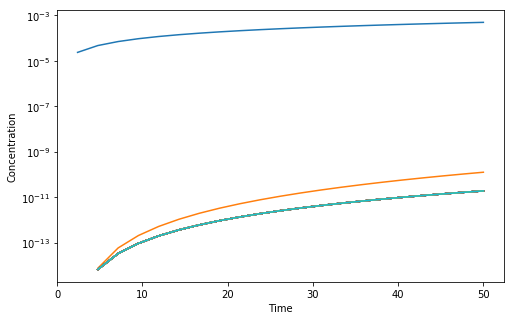

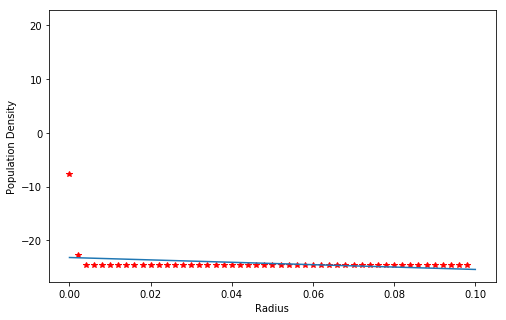

In [182]:
N = 50 # number of bins

# System parameters
n0 = 10**(-5) # nucleation rate
G = 10**(-6) # linear radial growth rate
H = 0.00001*np.ones((N,N))
#H = 0.0001*(np.diag(np.ones(N)) + 0.3*np.diag(np.ones(N-1),1) + 0.3*np.diag(np.ones(N-1),-1 ) + \
#    0.1*np.diag(np.ones(N-2),2) + 0.1*np.diag(np.ones(N-2),-2) + \
#    0.1*np.diag(np.ones(N-3),3) + 0.1*np.diag(np.ones(N-3),-3))

# Time
t0 = 0
tf = 50

# Maximum radius of interest
R = 0.1

# Discretize size bins
r = np.linspace(0,R,N+1)
dr = r[1:] - r[:-1]
rmin = r[:-1]
rmax = r[1:]

# Initial condition
u0 = np.zeros(N)
u[0,0] = n0

# Solve
r, V, t, u, c, tau = bubble_growth(R, n0, G, H, u0, t0, tf)

# Plotting
# Size distribution at all times
u[u==0] = 'nan'
fig,ax1 = plt.subplots(figsize=(8,5))
ax1.semilogy(t,u.transpose())
ax1.set_xlabel('Time')
ax1.set_ylabel('Concentration');

fig,ax2 = plt.subplots(figsize=(8,5))
n = u[u[:,-1]>0,-1]
n_true = n0*np.exp(tf/tau-r/(G*tau))

# Final population
ax2.plot(rmin[u[:,-1]>0],np.log(n),'r*')
ax2.plot(r,np.log(n_true),'k')
ax2.set_xlabel('Radius')
ax2.set_ylabel('Population Density');

# Line of best fit for exponential distribution
C = np.polyfit(rmin[u[:,-1]>0],np.log(n),1)
p = np.poly1d(C)
ax2.plot(r,p(r))
print(C)

In [176]:
np.sum(u0)

0.0